In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    Dropout,
    Dense,
    GlobalAveragePooling1D,
)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

Basic EDA and Data Visualization

In [57]:
print(train_data.head())
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
Training data shape: (159571, 8)
Test data shape: (153164, 2)


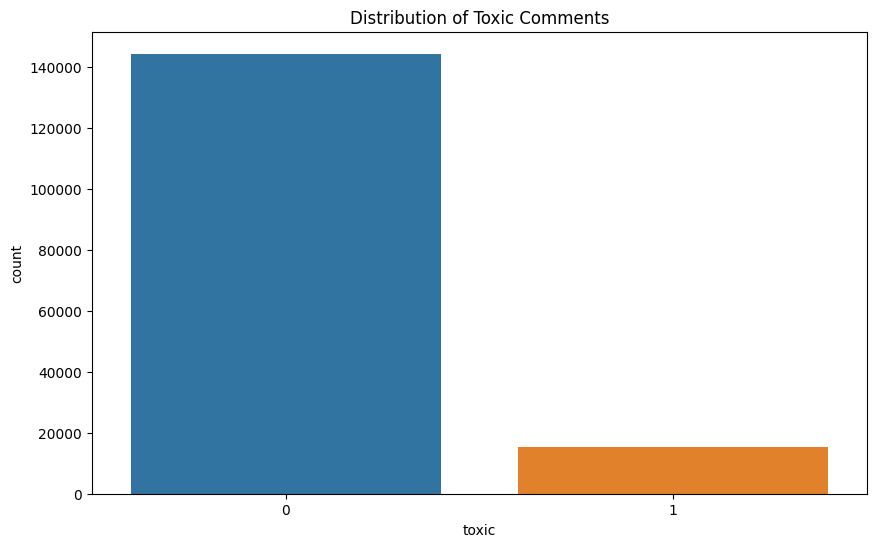

In [58]:
plt.figure(figsize=(10, 6))
sns.countplot(x="toxic", data=train_data)
plt.title("Distribution of Toxic Comments")
plt.show()

Preprocess

In [59]:
from sklearn.model_selection import train_test_split

max_features = 20000
max_len = 200

vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=max_len)
vectorizer.adapt(train_data["comment_text"].astype(str).values)

# Split data
x_train, x_val, y_train, y_val = train_test_split(
    train_data["comment_text"].astype(str).values,
    train_data.iloc[:, 2:].values,
    test_size=0.2,
    random_state=42,
)

# TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [60]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_dataset = train_dataset.map(lambda x, y: (vectorizer(x), y))
val_dataset = val_dataset.map(lambda x, y: (vectorizer(x), y))

batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Model building

In [61]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(max_features + 1, 128, input_length=max_len),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(
            6, activation="sigmoid"
        ),  # 6 output units for the 6 labels
    ]
)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 128)          2560128   
                                                                 
 dropout_7 (Dropout)         (None, 200, 128)          0         
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

Model Training

In [62]:
history = model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
1064/3990 [=======>......................] - ETA: 22s - loss: 0.1368 - accuracy: 0.8999

KeyboardInterrupt: 

Model Evaluation

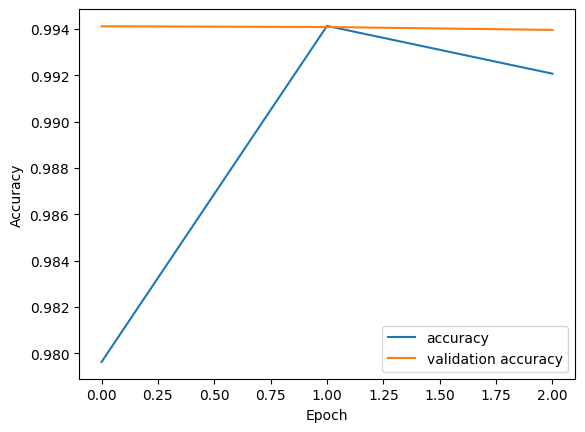

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Predictions for Test Data (for Kaggle Submission)

In [ ]:
# Vectorize the test data
x_test = test_data["comment_text"].astype(str).values
x_test = vectorizer(x_test)

# Predict
predictions = model.predict(x_test)

# Prepare submission file
submission = pd.DataFrame(
    predictions,
    columns=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"],
)
submission["id"] = test_data["id"]
submission.to_csv("submission.csv", index=False)

4787/4787 [==============================] - 4s 775us/step
